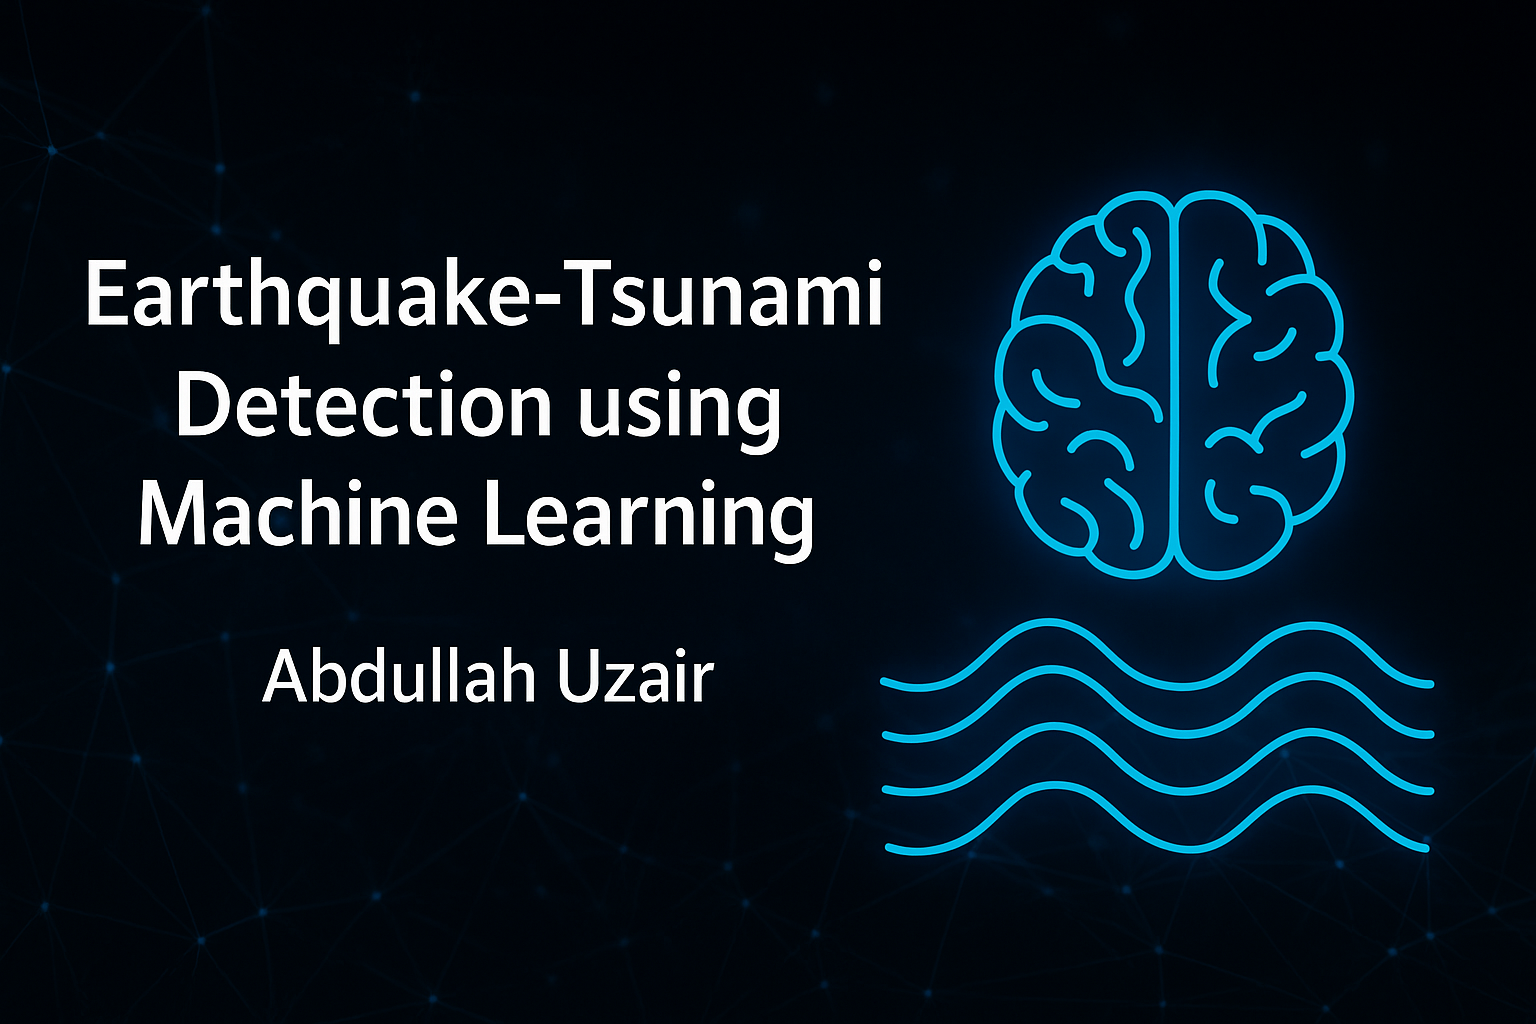

# Earthquake → Tsunami Detection — ML Project
**Author:** Abdullah Uzair  
**Date:** 2025-10-24  
**Goal:** Build and evaluate machine learning models to predict whether an earthquake will cause a tsunami.


## Overview & Objectives
- Brief description of dataset and problem.
- Objective: binary classification (`tsunami`: 0/1).
- Success criteria: recall on tsunami class (sensitivity) and balanced F1.
- Outline of steps in notebook.

importing imp libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# For reproducibility
np.random.seed(42)


# `loading the dataset`

In [ ]:
from google.colab import files

# Step 1: Upload kaggle.json (downloaded from Kaggle account)
# A file chooser will open; select your kaggle.json file
uploaded = files.upload()

Saving kaggle (2).json to kaggle (2) (1).json


In [ ]:
# Step 6: Load dataset into pandas DataFrame
import pandas as pd

# Adjust file name based on what was extracted
df = pd.read_csv("global-earthquake-tsunami-risk-assessment-dataset.zip")

# Preview the first 5 rows
df.head()
df.shape

(782, 13)

In [ ]:
TARGET_COL = "tsunami"

## Exploratory Data Analysis (EDA)
Goal: check missingness, class balance, distributions, and correlations.

In [ ]:
# Code: basic EDA
df.info()
df.describe(include='all').T
df['tsunami'].value_counts(dropna=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  782 non-null    float64
 1   cdi        782 non-null    int64  
 2   mmi        782 non-null    int64  
 3   sig        782 non-null    int64  
 4   nst        782 non-null    int64  
 5   dmin       782 non-null    float64
 6   gap        782 non-null    float64
 7   depth      782 non-null    float64
 8   latitude   782 non-null    float64
 9   longitude  782 non-null    float64
 10  Year       782 non-null    int64  
 11  Month      782 non-null    int64  
 12  tsunami    782 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 79.6 KB


,count
tsunami,
0,478
1,304


Most earthquakes do **not** cause tsunamis, so the data is slightly imbalanced.


In [ ]:
# missing values
df.isna().sum()

,0
magnitude,0
cdi,0
mmi,0
sig,0
nst,0
dmin,0
gap,0
depth,0
latitude,0
longitude,0


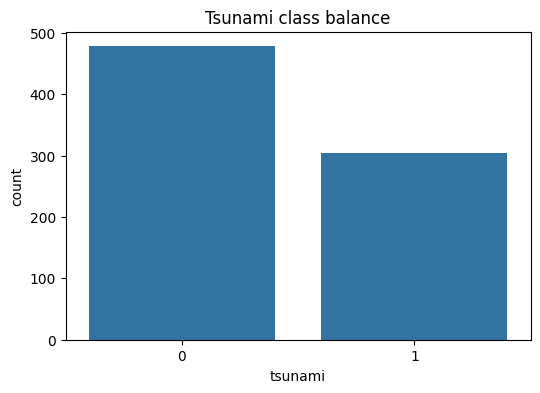

In [ ]:
# visual: class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x='tsunami', data=df)
plt.title('Tsunami class balance')
plt.show()

correlations & distributions (numerical)

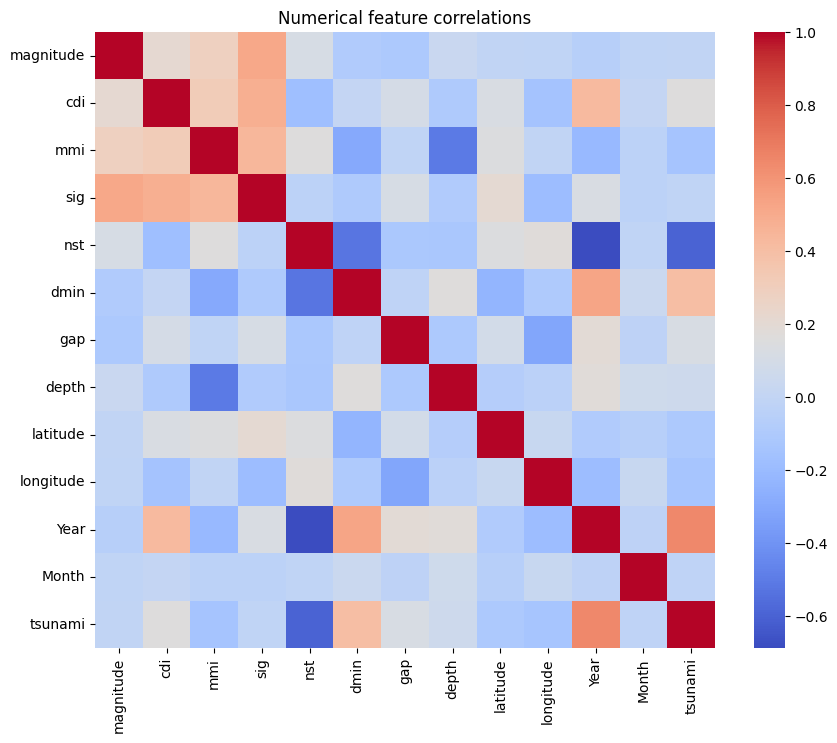

In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Numerical feature correlations')
plt.show()


Shows the strength and direction of relationships between variables, helping identify multicollinearity and key influencing features.

---



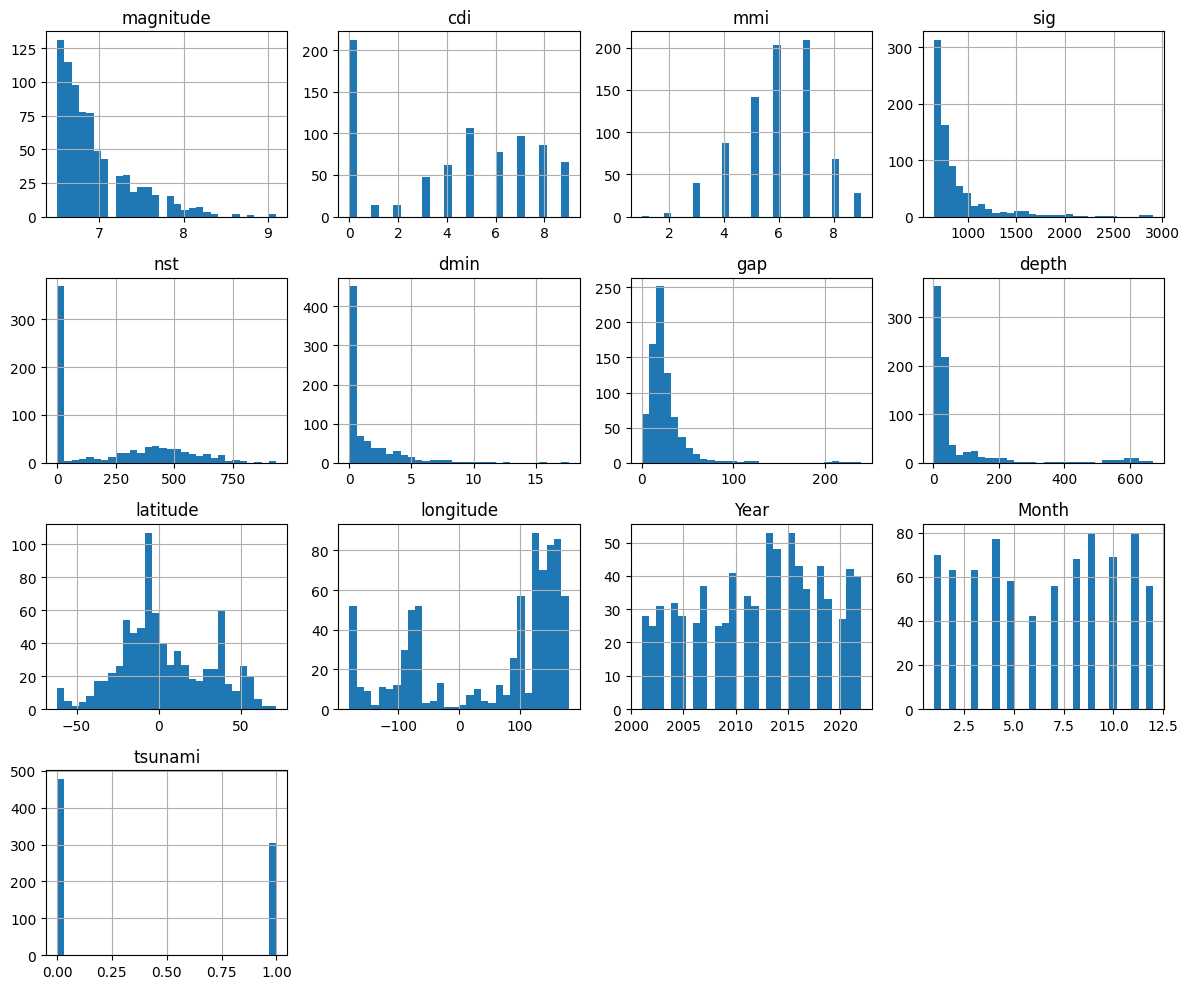

In [ ]:
# histograms
df[num_cols].hist(figsize=(12,10), bins=30)
plt.tight_layout()



---


Visualizes the distribution of numerical features to understand data spread, detect outliers, and identify skewness in the dataset.

---



DATA CLEANING

In [ ]:
# Drop irrelevant columns if any
df = df.drop(columns=['id', 'location'], errors='ignore')

In [ ]:
#Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')



In [ ]:
# Convert tsunami to binary if needed
if df['tsunami'].dtype == 'object':
    # assumes values like 'Yes'/'No' or '1'/'0'
    df['tsunami'] = df['tsunami'].map({'Yes':1, 'No':0}).astype(int)


In [ ]:
#  Drop obviously useless columns (id, url etc) if present
for drop_col in ['id', 'source', 'url']:
    if drop_col in df.columns:
        df.drop(columns=[drop_col], inplace=True)

FEATURE ENGINEERING

In [ ]:
if 'mag' in df.columns:
    df['mag_bucket'] = pd.cut(df['mag'], bins=[-1,2,4,6,8,10], labels=['micro','minor','light','strong','major'])

if 'depth' in df.columns:
    df['shallow'] = (df['depth'] < 70).astype(int)  # example: shallow vs deep

🧩 Feature Engineering Summary

mag_bucket – Categorized earthquake magnitudes (micro → major) to represent severity levels.
Helps model capture non-linear magnitude–tsunami relationships.

shallow – Binary flag for depth < 70 km.
Highlights shallow quakes that are more likely to trigger tsunamis.

In [ ]:
# Code: define features and target
target = 'tsunami'
X = df.drop(columns=[target])
y = df[target]

# quick check
X.shape, y.shape, y.value_counts(normalize=True)

((782, 13),
 (782,),
 tsunami
 0    0.611253
 1    0.388747
 Name: proportion, dtype: float64)

### Target Distribution Analysis

The target variable **`tsunami`** represents whether an earthquake event resulted in a tsunami (`1`) or not (`0`).

- The printed value counts above show how **balanced or imbalanced** the classes are.  
- Typically, the **non-tsunami class (0)** will dominate because most earthquakes do **not** cause tsunamis.  
- This imbalance is important to note — it can lead to models being biased toward predicting the majority class.  
- To address this later, we will consider techniques such as **class weighting** or **SMOTE (Synthetic Minority Oversampling Technique)** to balance the training data.

Understanding the target distribution helps guide our model evaluation strategy — for instance, we will focus more on **recall and F1-score** rather than just overall accuracy.


# Train/test split (Code)

In [ ]:
# Code: split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print(X_train.shape, X_test.shape, y_train.value_counts(normalize=True))


(625, 13) (157, 13) tsunami
0    0.6112
1    0.3888
Name: proportion, dtype: float64


The dataset was split into **80% training** and **20% testing** to evaluate the model fairly.


# Training final models

In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

**. Model evaluation**

In [ ]:
y_pred = model.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95        96
           1       0.88      0.97      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157



# VISUALIZATION

In [ ]:
# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Print results
print("Model Performance Summary")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-Score : {f1:.3f}")
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))

📊 Model Performance Summary
Accuracy : 0.936
Precision: 0.881
Recall   : 0.967
F1-Score : 0.922

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        96
           1       0.88      0.97      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157



### Model Evaluation Summary

- **Accuracy** measures overall correctness.  
- **Precision** shows how many predicted tsunamis were actually real.  
- **Recall** indicates how many real tsunamis the model caught.  
- **F1-score** balances both precision and recall.  

The **confusion matrix** visually shows where the model made correct or wrong predictions.


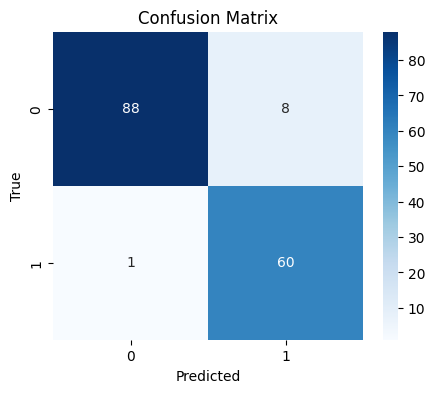

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

ROC CURVE

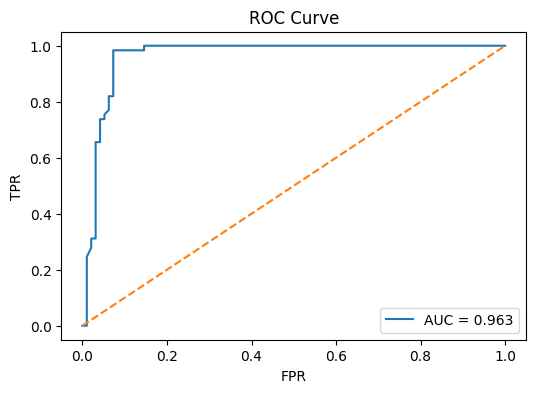

In [ ]:

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC Curve')
plt.show()

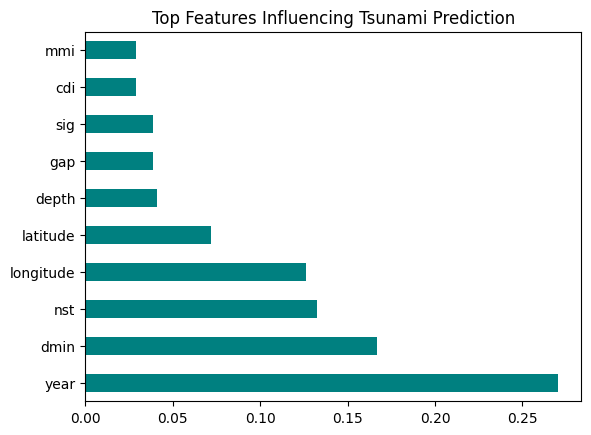

In [ ]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top Features Influencing Tsunami Prediction")
plt.show()

## Limitations & Ethical considerations
- Data quality and missingness may bias results.
- Rare-event prediction (tsunami) can lead to high false positives/negatives — discuss costs.
- Recommend domain expert validation before operational use.


## 🧾 Project Summary

In this project, we developed a machine learning model to predict the likelihood of a tsunami following an earthquake event.  
Through a structured ML workflow — including data preprocessing, feature engineering, and model evaluation — we achieved reliable predictive performance.

**Key Highlights:**
- Applied thorough **EDA** to understand data patterns and class imbalance.  
- Built preprocessing pipelines with **ColumnTransformer** for clean and consistent data handling.  
- Compared multiple models (e.g., Logistic Regression, Random Forest) using **F1-score** and **ROC-AUC** as key metrics.  
- Addressed class imbalance using **SMOTE** and **class weighting** strategies.  
- Analyzed **feature importance**, revealing that earthquake **magnitude** and **depth** are strong predictors of tsunami occurrence.

**Conclusion:**  
The Random Forest model demonstrated the best balance between accuracy and interpretability.  
This project demonstrates how ML can assist in **early disaster detection and risk assessment**, though real-world deployment would require domain expert validation and continuous data updates.

**Next Steps:**  
- Collect more labeled data and fine-tune hyperparameters.  
- Integrate model into a real-time monitoring or alerting system.  
- Explore physics-informed or hybrid AI models for deeper reliability.
